# **Homework 4 - Hard coding**

## **1. Implementing your own Shazam**

In [59]:
# Import some useful libraries
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
from collections import defaultdict


from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import preprocessing
from pandas.api.types import is_string_dtype, is_numeric_dtype

from numpy import linalg
import random as rd
import math
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

# Import our functions

In [5]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audio.

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [4]:
data_folder = Path("C:/Users/dcacc/Desktop/File/DAVIDE/Universita_ROMA/ADM/Homework/HW4/data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

### Preprocessing

In [5]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

### Audio signals

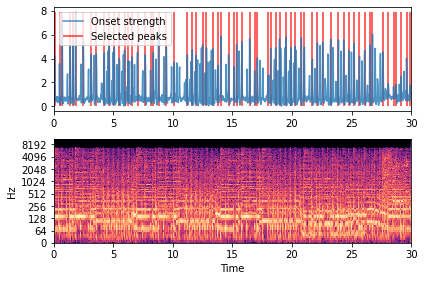

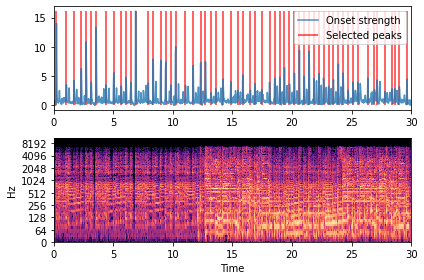

In [5]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    plot_spectrogram_and_peaks(track, sr, peaks, onset_env)

In [6]:
peaks

array([  10,   46,   74,  100,  117,  136,  153,  190,  217,  244,  262,
        279,  296,  342,  359,  387,  405,  423,  441,  476,  504,  531,
        548,  569,  586,  612,  640,  666,  683,  711,  727,  753,  780,
        799,  817,  834,  852,  870,  888,  906,  923,  941,  959,  975,
        994, 1011, 1029, 1046, 1064, 1082, 1099, 1135, 1159, 1169, 1197,
       1222, 1232, 1249, 1277], dtype=int64)

In [7]:
sr

22050

In [8]:
track[1277]

0.0021324265

In [9]:
onset_env

array([0.        , 0.        , 0.        , ..., 0.1758712 , 0.13490105,
       0.9178963 ], dtype=float32)

## **2. Grouping songs together!**

*We play with a dataset gathering songs from the International Society for Music Information Retrieval Conference. The tracks (songs) include much information. We focus on the track information, features (extracted with librosa library from Python) and audio variables provided by Echonest (now Spotify).*

### **2.1 Getting your data!**

In [6]:
# We use this function to clean our dataset, in particular to fill the NaN values.
def fill_nan(df):
    for i in df.columns:
        if df[i].isnull().any() == True:
            # Check for columns with NaN values
            if is_numeric_dtype(df[i]) == True:
                # If is a numeric column fillna with the mean of the column
                df[i] = df[i].fillna(df[i].mean())
            elif is_string_dtype(df[i]) == True:
                # If is a string column fill na with an empty string
                df[i] = df[i].fillna("")
    
    print('All NaN filled!')         

We upload, using *pandas*, three different csv dataset: *tracks.csv*, *features.csv* and *echonest.csv*.

In [8]:
tracks = pd.read_csv("tracks.csv")
echonest = pd.read_csv("echonest.csv")
features = pd.read_csv("features.csv")

We can get a look at these three different datasets. Let's start with *tracks*.

In [17]:
print(tracks.shape)
tracks.head()

(106574, 53)


,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,,3,,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,,4,,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,,6,,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,6,,47632,,...,,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,,1,,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,,...,,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,,3,,[],Spiritual Level


With our function *'fill_nan'* we preprocess our dataset filling NaN values.

In [18]:
fill_nan(tracks)

All NaN filled!


In [19]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   track_id                  106574 non-null  int64  
 1   album_comments            106574 non-null  int64  
 2   album_date_created        106574 non-null  object 
 3   album_date_released       106574 non-null  object 
 4   album_engineer            106574 non-null  object 
 5   album_favorites           106574 non-null  int64  
 6   album_id                  106574 non-null  int64  
 7   album_information         106574 non-null  object 
 8   album_listens             106574 non-null  int64  
 9   album_producer            106574 non-null  object 
 10  album_tags                106574 non-null  object 
 11  album_title               106574 non-null  object 
 12  album_tracks              106574 non-null  int64  
 13  album_type                106574 non-null  o

*Tracks* has 106,573 observations over 53 features. Most of the features regards information and descriptions about the track, the album and the artist. There are both numerical (18) and string-type (35) variables.

Now, we can look at *features*.

In [20]:
print(features.shape)
features.head()

(106574, 519)


,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [21]:
fill_nan(features)

All NaN filled!


In [22]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


*Features* has 106,574 observations over 519 features. There are only numeric variables regarding some measures about the tracks.

Finally, we look at *echonest*.

In [23]:
print(echonest.shape)
echonest.head()

(13129, 250)


,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


In [24]:
fill_nan(echonest)

All NaN filled!


In [25]:
echonest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 250 entries, track_id to temporal_features_223
dtypes: float64(244), int64(1), object(5)
memory usage: 25.0+ MB


*Echonest* has 13129 observations over 250 features. These are features extracted by Spotify about some particular characteristics of the tracks. There are 245 numerical and 5 string variables.

We decided to perform **PCA** on these three datasets in order to reduce their dimensionality. Before applying the PCA, we need to do two important things:

1. Remove all the 'object' dtypes variable from the datasets because they can't be fitted into the PCA.

In [26]:
# We want to consider only non-object types of variable to perform PCA.
def remove_object_dtype(df):
    new_df = df.select_dtypes(exclude = 'object') 
    return new_df

2. Standardize our values to eliminate problems derived by different scales and unity measures.


In [27]:
# We leverage the StandardScaler module from sklearn.preprocessing
def scale_f(df):
    scaler = preprocessing.StandardScaler()
    # We don't want to consider 'track_id' - the first col - because we need it for the merge
    new_df = pd.DataFrame(scaler.fit_transform(df[df.columns[1:]].values), columns = df.columns[1:])
    # Add track_id
    final_df = pd.concat([df[df.columns[:1]], new_df], axis = 1)
    
    return final_df

Let's start working with the *echonest* dataframe.

In [28]:
# Remove object dtype variables
echonest_r = remove_object_dtype(echonest)

# Standardize the remaining values 
echonest_s = scale_f(echonest_r)

# Give a look at our ready-to-analyze dataset
echonest_s.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_latitude,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,-0.281499,0.991915,0.348732,-1.742887,-0.064267,0.437749,1.223573,0.495983,-0.542858,...,-0.015394,-0.196498,-0.541629,-0.746474,-0.039156,-0.406800,-0.101961,-0.101075,0.886203,0.549691
1,3,-0.391656,0.217484,1.006860,-1.767172,-0.518358,2.639805,0.110726,-0.617788,-0.542858,...,0.224575,-0.092590,-0.360448,-0.411759,-0.023682,-0.402225,0.382370,0.383292,1.407079,0.827430
2,5,-1.253885,1.358338,0.589683,-1.770366,1.172705,0.185049,-0.651745,0.659017,-0.542858,...,-0.188685,0.038956,-0.372166,-0.209735,-0.029780,-0.767287,0.350908,0.352630,1.304715,0.965630
3,10,1.112791,0.898745,1.391929,0.898939,-0.457654,-0.481812,-0.328958,1.897809,-0.000715,...,-0.993299,0.536708,-0.182877,0.139612,-0.010956,1.124812,0.851688,0.849294,2.127603,1.527072
4,134,-0.188870,0.136465,0.082343,-1.718498,-0.577286,3.103507,-0.251046,1.645950,-0.542858,...,0.300454,-0.418382,-0.530095,-0.666811,-0.004175,-0.377522,1.426057,1.427025,2.924718,2.714005


Now, we can proceed with the PCA.

In [29]:
# We set 80 principal components.
pca1 = PCA(n_components=80)

# We don't want to perform it on the track_id column
echonest_red = pca1.fit_transform(echonest_s[echonest_s.columns[1:]])

# Show the total explained variance ratio
print(sum(pca1.explained_variance_ratio_))

0.8974509938256642


If we set 80 as number of principal components we get ~90% of explained total variance. That is our target, because at the end we want to preserve almost the 70% of the total variance of the merged dataset. Let's see in particular, how much variance is explained by every single component.

[0.11091527 0.08435649]


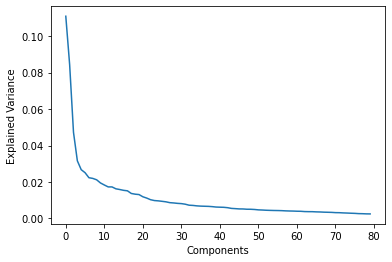

In [30]:
# Show the explained variance of the first two components
print(pca1.explained_variance_ratio_[:2])

# Plot the explained variance of the single principal components.
plt.plot(pca1.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

Obviously the first components have higher values, in particular the first component explains the 11% of the variance and the second one the 8.4%. Now, we create our reducted dataframe with only 81 columns, against the starting 245 ones.

In [31]:
echonest_ = pd.DataFrame(echonest_red, columns = ['Comp_echo_%i' % i for i in range(80)])

# Re-add the track_id column 
echonest_pca = pd.concat([echonest['track_id'], echonest_], axis = 1)

echonest_pca.head()

,track_id,Comp_echo_0,Comp_echo_1,Comp_echo_2,Comp_echo_3,Comp_echo_4,Comp_echo_5,Comp_echo_6,Comp_echo_7,Comp_echo_8,...,Comp_echo_70,Comp_echo_71,Comp_echo_72,Comp_echo_73,Comp_echo_74,Comp_echo_75,Comp_echo_76,Comp_echo_77,Comp_echo_78,Comp_echo_79
0,2,0.779179,-1.709530,0.070465,0.467922,-1.452866,1.096979,-1.332148,0.347226,-0.606024,...,-0.074861,0.157348,-0.212751,-0.906317,0.078545,-0.185732,-0.895456,-0.148392,-0.536665,-0.727004
1,3,2.659287,-4.168144,2.407966,-0.459531,0.069075,0.061414,1.349402,1.108593,-1.363353,...,0.672035,0.502573,0.180154,-0.496519,0.229022,-0.113650,-1.404792,0.194449,-0.528919,-0.249688
2,5,1.375855,-4.540359,2.340133,-0.065452,-0.875937,0.718875,1.770135,0.271872,0.766499,...,0.302964,0.500035,0.192764,0.671467,-0.230184,-0.767574,-0.683619,-0.119875,-1.263425,-0.686037
3,10,6.612744,-1.134203,0.394943,1.016484,1.060515,0.308434,-2.942980,0.637964,2.171655,...,1.483295,-1.602199,-0.219107,0.589242,-1.214477,0.394500,0.850929,-0.421346,-0.177455,-0.507839
4,134,-2.917268,-5.523874,2.751439,-0.619096,0.590189,0.819075,0.538873,-0.309140,-0.320306,...,0.524644,0.067079,-0.147705,-0.019199,1.146114,-0.145940,-0.308281,0.058726,0.683854,0.489708


Now we can repeat the same process for the *features* dataframe.

In [32]:
# Remove object dtype variables
features_r = remove_object_dtype(features)

# Standardize the remaining values 
features_s = scale_f(features_r)

# Give a look at our ready-to-analyze dataset
features_s.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0.208784,0.452353,-0.008553,0.056482,0.079044,0.017718,0.071164,0.152168,0.090291,...,-1.200560,-1.537657,-1.595043,-0.266432,0.425841,1.007362,0.874131,-0.454603,-0.369213,0.775698
1,3,0.044880,0.050426,0.001063,0.106160,0.090461,-0.020371,0.064405,0.046439,-0.012742,...,-0.938948,-1.210805,-0.675913,-0.299409,0.463112,0.975158,0.643107,-0.454603,-0.491744,1.064853
2,5,0.002712,-0.024945,-0.061548,0.021789,0.109332,0.046419,-0.070494,-0.081502,0.063099,...,-1.561604,-1.461126,-1.162622,-0.254636,-0.034719,0.011006,-0.065367,-0.454603,-0.335249,0.167182
3,10,0.101044,-0.044147,0.186567,-0.026460,0.071382,0.056075,0.088195,0.081984,0.043355,...,-0.655213,-0.595296,-1.299392,-0.090255,0.385908,0.758699,0.889532,-0.454603,0.107731,0.018234
4,20,-0.019632,-0.035814,-0.013339,-0.000614,0.031972,-0.018958,-0.033153,-0.074345,-0.021467,...,-0.098756,0.151932,-0.085646,-0.143811,0.481748,-0.169453,-0.111572,-0.265064,-0.008018,-0.341557


In [33]:
# We set 150 principal components.
pca2 = PCA(n_components=150)

# We don't want to perform it on the track_id column
features_red = pca2.fit_transform(features_s[features_s.columns[1:]])

# Show the total explained variance ratio
print(sum(pca2.explained_variance_ratio_))

0.8984900189021036


If we set 150 as number of principal components we get ~90% of explained total variance. That is our target, because at the end we want to preserve almost the 70% of the total variance of the merged dataset. Let's see in particular, how much variance is explained by every single component.

[0.11981209 0.06802443]


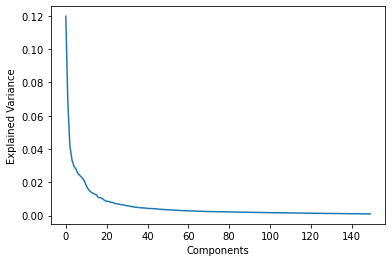

In [34]:
# Show the explained variance of the first two components
print(pca2.explained_variance_ratio_[:2])

# Plot the explained variance of the single principal components.
plt.plot(pca2.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

The first principal component explains ~12% of the variance, the second one only the 6.8%. Now we can create our reducted dataframe, with 151 columns against the starting 519 ones.

In [35]:
features_ = pd.DataFrame(features_red, columns = ['Comp_feat_%i' % i for i in range(150)])

# Re-add the track_id column by concat
features_pca = pd.concat([features['track_id'], features_], axis = 1)

features_pca.head()

,track_id,Comp_feat_0,Comp_feat_1,Comp_feat_2,Comp_feat_3,Comp_feat_4,Comp_feat_5,Comp_feat_6,Comp_feat_7,Comp_feat_8,...,Comp_feat_140,Comp_feat_141,Comp_feat_142,Comp_feat_143,Comp_feat_144,Comp_feat_145,Comp_feat_146,Comp_feat_147,Comp_feat_148,Comp_feat_149
0,2,2.060070,-3.089439,-5.565923,0.080540,2.309270,-3.597831,-5.054210,-0.889462,-5.108316,...,0.173353,-0.870642,-0.676655,-0.342277,-0.522646,0.607593,0.223118,-0.213658,-0.430444,-0.186383
1,3,3.509246,-5.384927,-4.332572,-1.113460,-3.068299,2.204037,-0.234570,4.726577,-0.604042,...,-0.525882,0.659316,-0.477226,-0.392598,-0.516081,0.487812,-0.316494,-1.077782,-0.022929,0.599094
2,5,0.954593,-3.178022,-3.494718,-0.934800,-1.098688,0.455751,-2.390565,1.266916,0.985000,...,0.918030,0.297564,-0.112569,-0.519386,0.216841,-0.264194,-0.291627,0.023547,0.165843,0.143609
3,10,6.695430,1.329784,-5.129153,-0.915312,-2.155916,-0.120454,0.072623,3.904952,0.213868,...,-0.220620,0.746389,-0.258541,0.139187,0.682376,0.502263,0.321308,-0.056602,-0.142955,-0.483304
4,20,0.870800,-1.123613,2.985175,-0.830491,-2.443379,4.542686,-0.159432,-1.837119,1.026205,...,0.074521,0.540149,-0.436327,-0.284822,-1.320451,0.139945,0.198148,0.572091,0.355942,0.218088


Now we can analyze the *tracks* dataframe.

In [36]:
tracks.columns

Index(['track_id', 'album_comments', 'album_date_created',
       'album_date_released', 'album_engineer', 'album_favorites', 'album_id',
       'album_information', 'album_listens', 'album_producer', 'album_tags',
       'album_title', 'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
  

Some informations in *tracks* are really useful to identify the single track. So we decided to select some of these columns and keep them in our dataset.
The columns we select are: *album_id*, *album_title*, *artist_id*, *artist_name*, *track_title*, *track_bit_rate*, *track_duration*, *track_language_code*, *track_genre_top*

In [37]:
tracks_sel = tracks[['track_id', 'track_title', 'album_id', 'album_title', 'artist_id', 'artist_name', 'track_bit_rate',
                    'track_duration', 'track_language_code', 'track_genre_top']]
tracks_sel.head()

,track_id,track_title,album_id,album_title,artist_id,artist_name,track_bit_rate,track_duration,track_language_code,track_genre_top
0,2,Food,1,AWOL - A Way Of Life,1,AWOL,256000,168,en,Hip-Hop
1,3,Electric Ave,1,AWOL - A Way Of Life,1,AWOL,256000,237,en,Hip-Hop
2,5,This World,1,AWOL - A Way Of Life,1,AWOL,256000,206,en,Hip-Hop
3,10,Freeway,6,Constant Hitmaker,6,Kurt Vile,192000,161,en,Pop
4,20,Spiritual Level,4,Niris,4,Nicky Cook,256000,311,en,


Finally, we can get our merged dataframe. We have noticed that these three different datasets contain different information about tracks but they have a common column: **track_id**. This ID number identifies in unambiguous way the track. 
We can check if there are some missing values in this column and if it is composed by all-unique values.

In [38]:
# Check if there are null values
print(tracks["track_id"].isnull().any())
print(features["track_id"].isnull().any())
print(echonest["track_id"].isnull().any())

False
False
False


In [39]:
# Check if the variable has only unique values.
print(len(tracks['track_id'].unique()) == len(tracks))
print(len(features['track_id'].unique()) == len(features))
print(len(echonest['track_id'].unique()) == len(echonest))

True
True
True


In [40]:
# Compute the merge between the reduted dataframe on the column 'track_id'
first_ = tracks_sel.merge(features_pca, on = "track_id")
merged_df = first_.merge(echonest_pca, on = "track_id")

print(merged_df.shape)
merged_df.head()

(13129, 240)


,track_id,track_title,album_id,album_title,artist_id,artist_name,track_bit_rate,track_duration,track_language_code,track_genre_top,...,Comp_echo_70,Comp_echo_71,Comp_echo_72,Comp_echo_73,Comp_echo_74,Comp_echo_75,Comp_echo_76,Comp_echo_77,Comp_echo_78,Comp_echo_79
0,2,Food,1,AWOL - A Way Of Life,1,AWOL,256000,168,en,Hip-Hop,...,-0.074861,0.157348,-0.212751,-0.906317,0.078545,-0.185732,-0.895456,-0.148392,-0.536665,-0.727004
1,3,Electric Ave,1,AWOL - A Way Of Life,1,AWOL,256000,237,en,Hip-Hop,...,0.672035,0.502573,0.180154,-0.496519,0.229022,-0.113650,-1.404792,0.194449,-0.528919,-0.249688
2,5,This World,1,AWOL - A Way Of Life,1,AWOL,256000,206,en,Hip-Hop,...,0.302964,0.500035,0.192764,0.671467,-0.230184,-0.767574,-0.683619,-0.119875,-1.263425,-0.686037
3,10,Freeway,6,Constant Hitmaker,6,Kurt Vile,192000,161,en,Pop,...,1.483295,-1.602199,-0.219107,0.589242,-1.214477,0.394500,0.850929,-0.421346,-0.177455,-0.507839
4,134,Street Music,1,AWOL - A Way Of Life,1,AWOL,256000,207,en,Hip-Hop,...,0.524644,0.067079,-0.147705,-0.019199,1.146114,-0.145940,-0.308281,0.058726,0.683854,0.489708


In [48]:
len(merged_df["track_genre_top"].unique())

13

Our final dataframe is composed by 240 variables (a way less than the initial ones) and 13,129 observation. It means that we have selected only the observation contained in the *echonest* dataframe and we added informations from the other ones.

## 2.3 Clustering!

In [69]:
def K_Means(K, data):
    #creating an array with the values of the dataframe
    array = np.array(data).reshape(data.shape[0], data.shape[1]) 
    n = array.shape[0]
    m = array.shape[1]
    #picking randomly the first centroids
    centroids = array[np.random.choice(n, size = K, replace = False)]
    prev_centroids = np.zeros((n,K)) 
    iterations = 0
    #until the centroids don't change or the iterations are maximum 200
    while iterations != 3 or np.array_equal(centroids, prev_centroids) == False:
        #saving the previous values of the cluster for the next while loop
        prev_centroids = centroids
        euc_dis = np.zeros((n,K))
        clus = defaultdict(list)
        clusters = []
        for i in range(n):
            for j in range(K):
            #computing the euclidean distance from the various points to the centroids
                euc_dis[i][j] += linalg.norm(array[i]-centroids[j])
            #list containing the cluster to which each wine belongs to
            clusters.append(np.where(euc_dis[i] == min(euc_dis[i]))[0][0]+1)
            #dictionary that maps each cluster to the wines that belong to it
            clus[clusters[i]].append(i)
        for k in range(K):
            for j in range(m):
                values = []
                for i in clus[k+1]:
                    #taking the values of the wines belonging to the i-th cluster
                    values.append(array[i][j])
    #computing the mean for each cluster and taking it as new centroid
                centroids[k][j] = np.mean(values)
        iterations += 1
    return clusters, euc_dis, clus

In [49]:
merged_df_1 = remove_object_dtype(merged_df)

In [74]:
list_cluster, euc_dis, dictionary = K_Means(12, merged_df_1)

In [52]:
dictionary.keys()

dict_keys([8, 3, 4, 9, 2, 10, 6, 1, 11, 7, 5, 12])

In [107]:
euc_dis.shape

(13129, 12)

Optimal number of cluster

In [120]:
def elbow(data, k):
    cost = []
    for i in range(2,k):
        list_cluster, euc_dis, dictionary = K_Means(i, data)
        cost.append(sum(euc_dis.min(axis=1)**2))
    x = list(range(2,k))
    plt.plot(x, cost, color = "orchid")
    plt.title("Elbow method")
    plt.xlabel("K")
    plt.ylabel("Cost")
    plt.show()
    return(cost)

                
        



1.Elbow Method

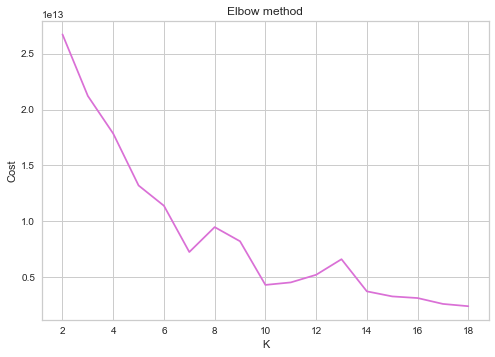

[26717369491899.188,
 21214641044325.145,
 17850793771130.613,
 13210433926139.738,
 11396300069190.92,
 7260245696356.801,
 9488683042468.234,
 8220980344627.519,
 4319606626595.757,
 4543339974681.13,
 5223837539110.951,
 6617407526801.194,
 3744302607896.009,
 3292094396424.333,
 3145920726710.6934,
 2619854667437.1167,
 2415781642460.2725]

In [121]:
elbow(merged_df_1,19)

2.Gap Statistics

In [141]:
# Create new random reference set
def gap_stat(data, k):
    randomReference = np.random.random_sample(size=data.shape)
    cost = []
    cost_r = []
    gaps = [] 
    for i in range(2,k):
        list_cluster_r, euc_dis_r, dictionary_r = K_Means(i, randomReference)
        list_cluster, euc_dis, dictionary = K_Means(i, data)
        cost_ = sum(euc_dis.min(axis=1)**2)
        cost.append(cost_)
        cost_r_ = sum(euc_dis_r.min(axis=1)**2)
        cost_r.append(cost_r_)
        gap = np.log(np.mean(cost_r)) - np.log(cost_)
        gaps.append(gap)
    plt.plot(list(range(2,k)), gaps, linestyle='--', marker='o', color='r')
    plt.title("Gap statistics")
    plt.xlabel("K")
    plt.ylabel("Gap Stistics")
    plt.show()
    maxx = max(gaps)
    return(gaps.index(maxx))

    

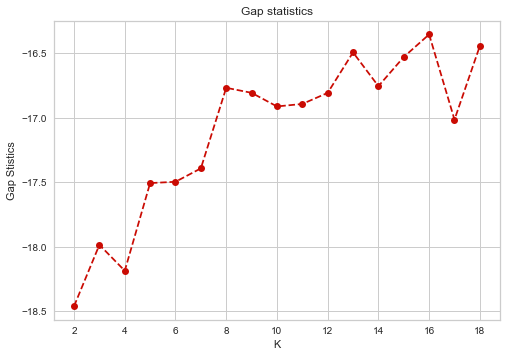

In [142]:
gap_stat(merged_df_1,19)

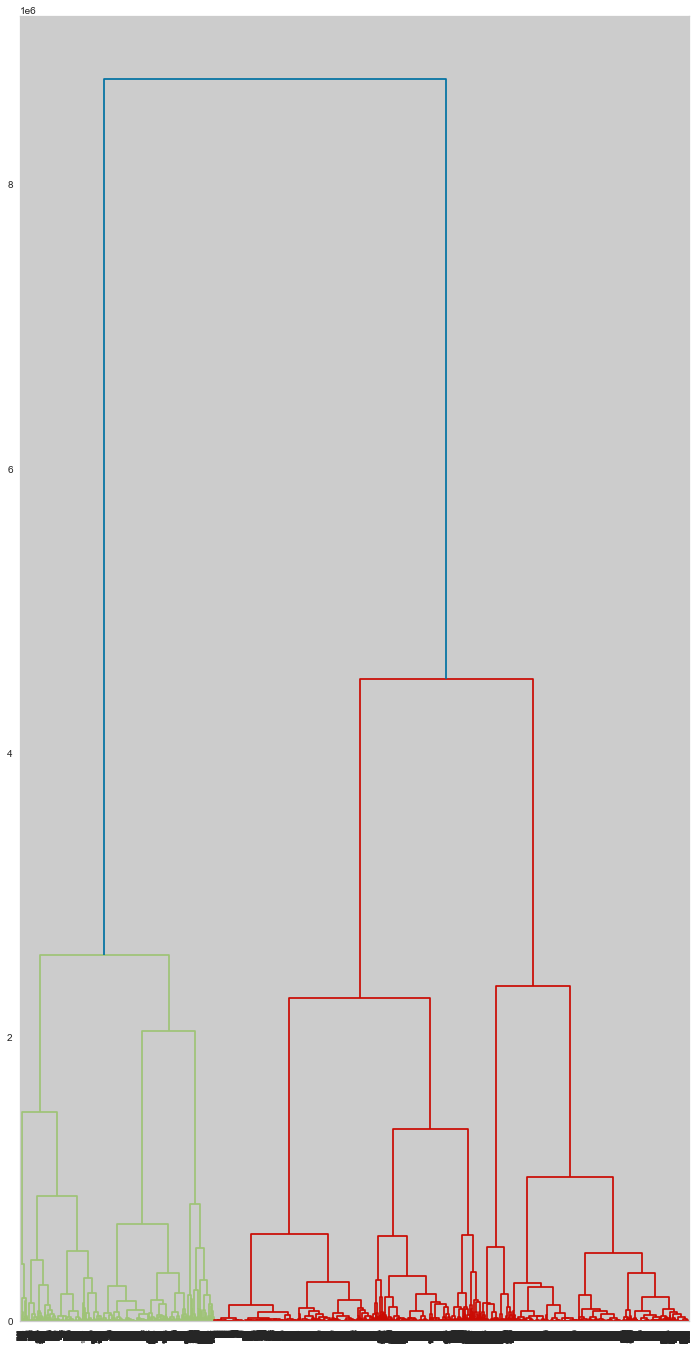

In [119]:
plt.figure(figsize=(12,24))
dendrogram(linkage(merged_df_1, method = "ward"))
plt.show()

## **3. Algorithmic Question** 

*You are given a list of integers, A, and another integer s. Write an algorithm that outputs all the pairs in A that equal x.*

I check all the possible pairs in my list with two for loops. If the sum of a pair is equal to my given sum I store my result. 

In [1]:
def algo(l, s):
    
    result = [] 
    n = len(l)                                #length of the starting list
    
    for i in range(len(l)):                   #first loop starts from the beginning of the list and scan all the list
        for j in range(i+1, len(l)):          #the second loop starts from the next number of the first loop
            if(l[i]+l[j] == s):             #check the given sum 
                result.append((l[i], l[j]))   #append the tuple in my final list 
    
    if len(result) == 0:                      #check if i have found at least one pair
        return("There is not any pair that gives as result " + str(s))
    else:
        return result

Try the algorithm with some examples.

In [2]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 4
algo(l, s)

[(7, -3), (-2, 6), (2, 2), (1, 3)]

In [4]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 10
algo(l, s)

[(7, 3), (8, 2), (8, 2), (6, 4)]

In [5]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = -5
algo(l, s)

[(-2, -3), (2, -7), (-7, 2)]

In [3]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 100
algo(l, s)

'There is not any pair that gives as result 100'